In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.ndimage import binary_erosion
import fnmatch
import torch
from train.testing import testing
from data_processing.dataset_3d import load_dataset_3d
from data_processing.obj2py import read_get, read_mat, read_egt
from data_processing.helper import sort_filenames, erode_lung_masks, combine_electrode_positions
import copy
from plotting_helper import *
import scipy

In [36]:
# eit_path = 'outputs/2024-08-21/16-15-17'
eit_path = 'outputs/2024-08-29/18-59-20'
model, cfg = load_model(eit_path, device='cuda:2')

In [37]:
# cfg.learning.training.device = 'cuda:1'

In [38]:
cases = get_all_cases(cfg, base_dir='')    
train_dataset, val_dataset, test_dataset = load_dataset_3d(cases,
            resolution=cfg.data.resolution, 
            base_dir = '',
            raw_data_folder=cfg.data.raw_data_folder, 
            processed_data_folder='data/processed/3d',
            dataset_data_folder=cfg.data.dataset_data_folder,
            name_prefix=cfg.data.name_prefix,
            write_dataset=True, write_npz=True, 
            overwrite_npz=False, n_sample_points=cfg.learning.training.sample_points,
            apply_rotation=cfg.data.apply_rotation,
            apply_subsampling=cfg.data.apply_subsampling,
            apply_translation = cfg.data.apply_translation,
            translation_x=cfg.data.translation_x, translation_y=cfg.data.translation_y, translation_z=cfg.data.translation_z,
            point_levels_3d=cfg.data.point_levels_3d,
            multi_process=cfg.data.multi_process, num_workers=cfg.data.num_workers,
            signal_norm='all',
            normalize_space='xy'
            )
test_dataset.case_files = sort_filenames(test_dataset.case_files)

Using 128 workers.


237it [00:52,  4.50it/s]

Training set: 852, validation set: 96, test set: 120


In [39]:
np.save('data_processing/normalizing_metrics/norm_signals.npy', np.concatenate([test_dataset.train_mean.numpy(), test_dataset.train_std.numpy()], axis=0))
np.save('data_processing/normalizing_metrics/norm_electrodes.npy', np.stack([test_dataset.points_max.numpy(), test_dataset.points_min.numpy()], axis=0))

In [61]:
def inference(model, signals, electrodes, points=None, device='cuda', resolution=512, zpos=None, signals_mask=None, n_zpos=4, z_padding=0):
    # standardize
    signals_mean, signals_std = np.load('data_processing/normalizing_metrics/norm_signals.npy')
    if len(signals.shape) <= 3:
        signals = signals.reshape(-1, signals_mean.shape[1], signals_mean.shape[2])
        signals = signals[None]
    if len(electrodes.shape) <= 3:
        electrodes = combine_electrode_positions(electrodes)
        electrodes = electrodes[None]
    else:
        e_tmp = []
        for i in range(electrodes.shape[0]):
            e_tmp.append(combine_electrode_positions(electrodes[i]))
        electrodes = np.stack(e_tmp, axis=0)
    batch_size = signals.shape[0]
    if signals_mask is None:
        mask = np.zeros(signals_mean.shape, dtype=bool)
        avail_dim = signals.shape[1]
        if avail_dim <= 4:
            mask[:avail_dim] = True
        else:
            mask[:] = True
    signals_mean = signals_mean[mask].reshape(signals.shape[1:])
    signals_std = signals_std[mask].reshape(signals.shape[1:])
    signals = signals.reshape(batch_size, signals_mean.shape[0], signals_mean.shape[1],signals_mean.shape[2])
    signals = ((signals - signals_mean) / signals_std).reshape(batch_size, signals.shape[1], -1)
    
    points_max, points_min = np.load('data_processing/normalizing_metrics/norm_electrodes.npy')
    electrodes = ((electrodes - points_min) / (points_max - points_min)) * 2 - 1
    if zpos is None:
        max_z = np.max(electrodes.reshape(-1,3)[:,-1])
        min_z = np.min(electrodes.reshape(-1,3)[:,-1])
        zpos = np.linspace(max_z+z_padding, min_z, n_zpos)
    if points is None:
        # get max and min points from electrode positions
        max_x, max_y, max_z = np.max(electrodes.reshape(-1,3), axis=0)
        min_x, min_y, min_z = np.min(electrodes.reshape(-1,3), axis=0)
        # min = np.min([min_x, min_y])
        # max = np.max([max_x, max_y])
        x = np.linspace(min_x, max_x, resolution)
        y = np.linspace(min_y, max_y, resolution)
        xy = np.meshgrid(x, y)
        xy = np.stack(xy, axis=-1)
        xy = xy.reshape(-1,2)
        xyz = []
        for zi in zpos:
            z = np.ones_like(xy[:,0])*zi
            xyz.append(np.concatenate([xy, z.reshape(-1,1)], axis=1))
        xyz = np.concatenate(xyz, axis=0)
        points = np.tile(xyz, (batch_size, 1, 1))
    if batch_size > 1:
        pred_tmp = []
        for i in range(batch_size):
            _, pred, _ = testing(model, [signals[i][None], electrodes[i][None], points[i][None]], device=device, wandb_log=False, point_levels_3d=len(zpos), point_chunks=len(zpos))
            pred_tmp.append(pred.cpu())
        pred = torch.stack(pred_tmp, dim=0)
    else:
        _, pred, _ = testing(model, [signals, electrodes, points], device=device, wandb_log=False, point_levels_3d=len(zpos), point_chunks=len(zpos))
    return pred

    
    

# KI_EIT Study

In [ ]:
protocol = 12
test_signals_top = read_get('/home/nibdombe/deep_eit/data/raw/case_real/Ki_EIT_01/KI_EIT_01_0'+str(protocol)+'_SF_1_U_top_I_top.get')[:208].reshape(-1,16,13)
test_signals_mid = read_get('/home/nibdombe/deep_eit/data/raw/case_real/Ki_EIT_01/KI_EIT_01_0'+str(protocol)+'_SF_2_U_mid_I_mid.get')[:208].reshape(-1,16,13)
test_signals_bot = read_get('/home/nibdombe/deep_eit/data/raw/case_real/Ki_EIT_01/KI_EIT_01_0'+str(protocol)+'_SF_3_U_bot_I_bot.get')[:208].reshape(-1,16,13)
test_signals = np.concatenate([test_signals_top, test_signals_mid, test_signals_bot], axis=0)
test_electrodes = np.load('/home/nibdombe/deep_eit/data/processed/3d_15/case_TCIA_405_0/case_TCIA_405_0_20.npz')['electrodes']
plt.plot(test_signals.reshape(-1))

12


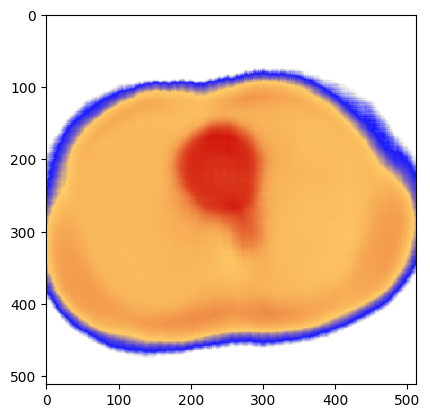

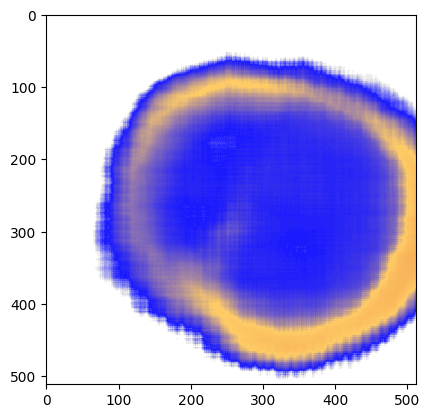

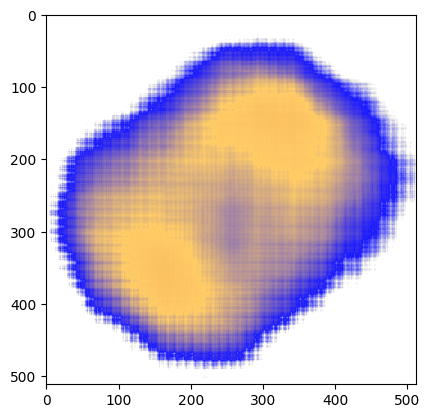

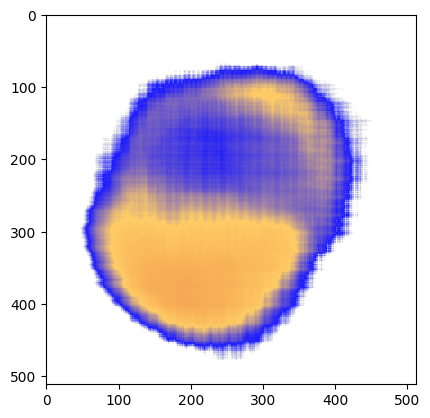

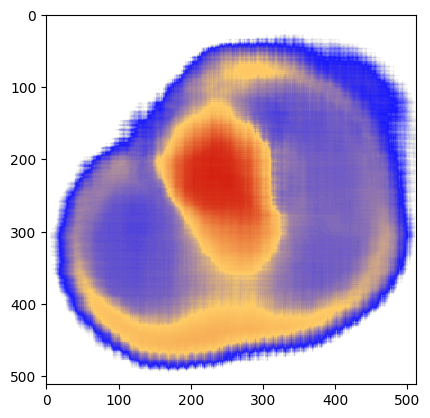

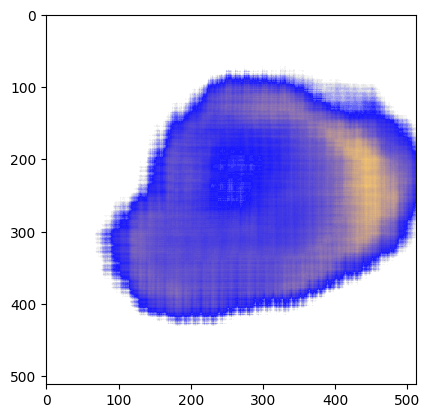

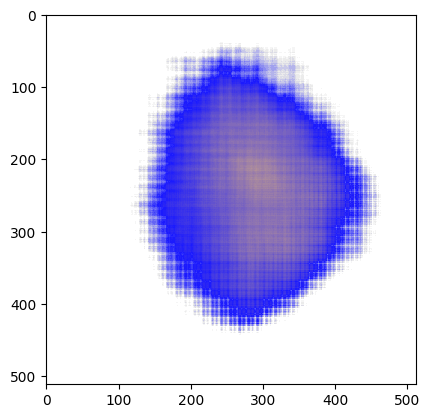

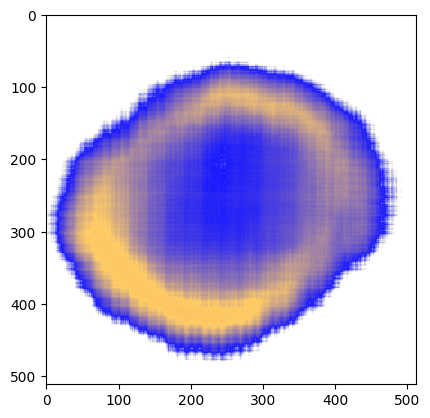

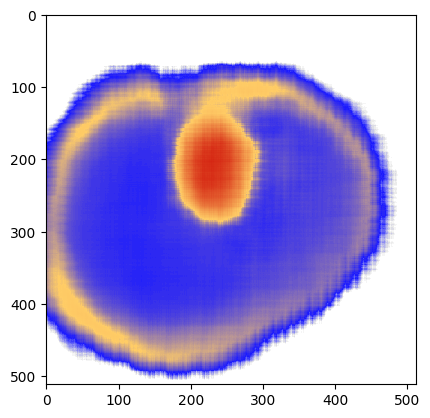

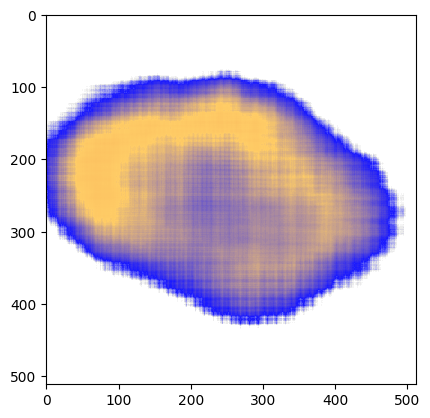

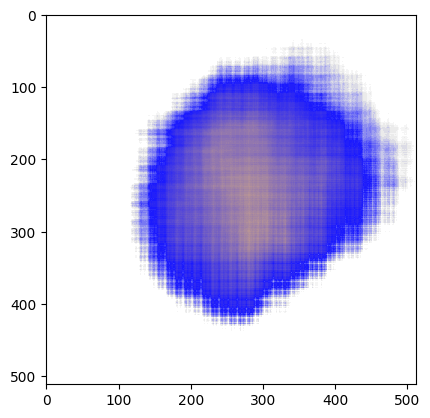

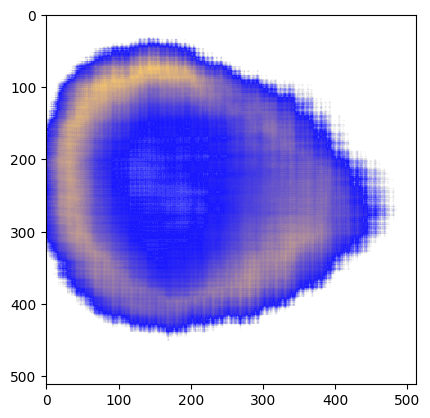

In [13]:
for i in range(12,30):
    multiplier = 1000/4.5
    # protocol = 12
    protocol = f'{i:02}'
    print(protocol)
    for j in range(0,100,9):
        test_signals_top = read_get('/home/nibdombe/deep_eit/data/raw/case_real/Ki_EIT_01/KI_EIT_01_0'+str(protocol)+'_SF_1_U_top_I_top.get')[j*208:(j+1)*208].reshape(-1,16,13)
        test_signals_mid = read_get('/home/nibdombe/deep_eit/data/raw/case_real/Ki_EIT_01/KI_EIT_01_0'+str(protocol)+'_SF_2_U_mid_I_mid.get')[j*208:(j+1)*208].reshape(-1,16,13)
        test_signals_bot = read_get('/home/nibdombe/deep_eit/data/raw/case_real/Ki_EIT_01/KI_EIT_01_0'+str(protocol)+'_SF_3_U_bot_I_bot.get')[j*208:(j+1)*208].reshape(-1,16,13)
        test_signals = np.concatenate([test_signals_top, test_signals_mid, test_signals_bot], axis=0) * multiplier
        test_electrodes = np.load('/home/nibdombe/deep_eit/data/processed/3d_15/case_TCIA_405_0/case_TCIA_405_0_20.npz')['electrodes'][:3]
        pred = inference(model, test_signals, test_electrodes, device='cuda:2')
        plt.imshow(pred[0], cmap=cmap, vmin=0, vmax=0.7)
        plt.show()
    break
    if i == 25:
        break
    

In [ ]:
for i in range(len(train_dataset)):
    s = np.load(os.path.join('data/processed/3d_15', train_dataset.case_files[i]))['signals']
    print(train_dataset.case_files[i], s.mean())

In [ ]:
test_electrodes = read_mat('data/raw/case_0/electrodes/electrodes.mat').reshape(-1, 16, 3)
print(test_electrodes)

In [ ]:
np.loadtxt('/home/nibdombe/deep_eit/data/raw/case_TCIA_124_0/electrodes/electrodes.txt')

# Parabula flights

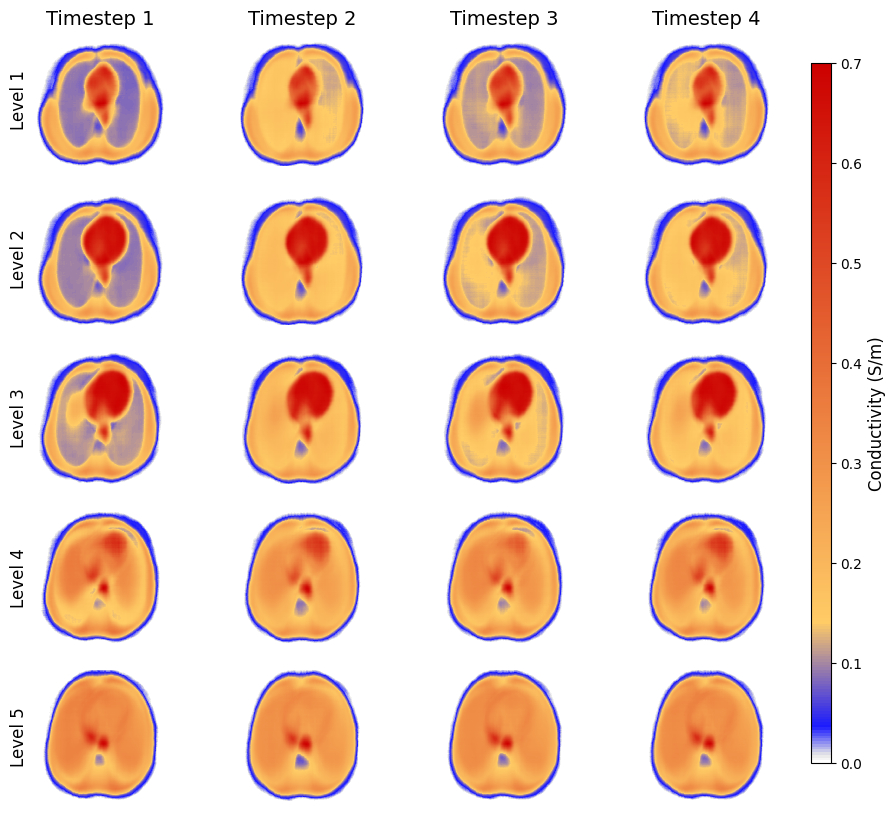

In [110]:
# for i in range(0,5):
protocol = '19'
n_zpos = 5
device = 'cuda:3'
multiplier = 1000/4.5
preds = []

test_signals_top = read_get('/home/nibdombe/deep_eit/data/raw/case_real/Tag1/Tag_01_Msg_'+protocol+'_SF_1_U_top_I_top_193-321_min_mean.get')[:208].reshape(-1,16,13)
test_signals_mid = read_get('/home/nibdombe/deep_eit/data/raw/case_real/Tag1/Tag_01_Msg_'+protocol+'_SF_2_U_mid_I_mid_193-321_min_mean.get')[:208].reshape(-1,16,13)
test_signals_bot = read_get('/home/nibdombe/deep_eit/data/raw/case_real/Tag1/Tag_01_Msg_'+protocol+'_SF_3_U_bot_I_bot_193-321_min_mean.get')[:208].reshape(-1,16,13)
test_signals = np.concatenate([test_signals_top, test_signals_mid, test_signals_bot], axis=0)*multiplier
test_electrodes = read_mat('data/raw/case_0/electrodes/electrodes.mat').reshape(-1, 16, 3)[[0,2,4]]
test_electrodes = test_electrodes - test_electrodes[0,0]
# test_electrodes_z = np.load('/home/nibdombe/deep_eit/data/processed/3d_15/case_TCIA_405_0/case_TCIA_405_0_20.npz')['electrodes']
# test_electrodes[:,:,2] = test_electrodes_z[:3,:,2]

pred = inference(model, test_signals, test_electrodes, n_zpos=n_zpos, z_padding=0., device=device)
preds.append(pred)

test_signals_top = read_get('/home/nibdombe/deep_eit/data/raw/case_real/Tag1/Tag_01_Msg_'+protocol+'_SF_1_U_top_I_top_372-459_min_mean.get')[:208].reshape(-1,16,13)
test_signals_mid = read_get('/home/nibdombe/deep_eit/data/raw/case_real/Tag1/Tag_01_Msg_'+protocol+'_SF_2_U_mid_I_mid_372-459_min_mean.get')[:208].reshape(-1,16,13)
test_signals_bot = read_get('/home/nibdombe/deep_eit/data/raw/case_real/Tag1/Tag_01_Msg_'+protocol+'_SF_3_U_bot_I_bot_372-459_min_mean.get')[:208].reshape(-1,16,13)
test_signals = np.concatenate([test_signals_top, test_signals_mid, test_signals_bot], axis=0)*multiplier
pred = inference(model, test_signals, test_electrodes, n_zpos=n_zpos, z_padding=0., device=device)
preds.append(pred)

test_signals_top = read_get('/home/nibdombe/deep_eit/data/raw/case_real/Tag1/Tag_01_Msg_'+protocol+'_SF_1_U_top_I_top_550-642_min_mean.get')[:208].reshape(-1,16,13)
test_signals_mid = read_get('/home/nibdombe/deep_eit/data/raw/case_real/Tag1/Tag_01_Msg_'+protocol+'_SF_2_U_mid_I_mid_550-642_min_mean.get')[:208].reshape(-1,16,13)
test_signals_bot = read_get('/home/nibdombe/deep_eit/data/raw/case_real/Tag1/Tag_01_Msg_'+protocol+'_SF_3_U_bot_I_bot_550-642_min_mean.get')[:208].reshape(-1,16,13)
test_signals = np.concatenate([test_signals_top, test_signals_mid, test_signals_bot], axis=0)*multiplier
pred = inference(model, test_signals, test_electrodes, n_zpos=n_zpos, z_padding=0., device=device)
preds.append(pred)

test_signals_top = read_get('/home/nibdombe/deep_eit/data/raw/case_real/Tag1/Tag_01_Msg_'+protocol+'_SF_1_U_top_I_top_792-938_min_mean.get')[:208].reshape(-1,16,13)
test_signals_mid = read_get('/home/nibdombe/deep_eit/data/raw/case_real/Tag1/Tag_01_Msg_'+protocol+'_SF_2_U_mid_I_mid_792-938_min_mean.get')[:208].reshape(-1,16,13)
test_signals_bot = read_get('/home/nibdombe/deep_eit/data/raw/case_real/Tag1/Tag_01_Msg_'+protocol+'_SF_3_U_bot_I_bot_792-938_min_mean.get')[:208].reshape(-1,16,13)
test_signals = np.concatenate([test_signals_top, test_signals_mid, test_signals_bot], axis=0)*multiplier
pred = inference(model, test_signals, test_electrodes, n_zpos=n_zpos, z_padding=0., device=device)
preds.append(pred)

preds = np.stack(preds, axis=0)

fig, axes = plt.subplots(n_zpos, 4, figsize=(10, 10))
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # [left, bottom, width, height]

for i in range(n_zpos): 
    for j in range(4):
        if i==0:
            axes[i,j].set_title(f'Timestep {j+1}')
        axes[i, j].imshow(preds[j][i], cmap=cmap, vmin=0, vmax=0.7)
        if j==0:
            axes[i, j].set_ylabel(f'Level {i+1}')
            # Hide x-axis and y-axis ticks and tick labels
            axes[i,j].xaxis.set_visible(False)
            axes[i,j].tick_params(axis='y', which='both', left=False, right=False, labelleft=False)

            # Hide the spines (the lines bounding the plot area)
            axes[i,j].spines['top'].set_visible(False)
            axes[i,j].spines['bottom'].set_visible(False)
            axes[i,j].spines['left'].set_visible(False)
            axes[i,j].spines['right'].set_visible(False)
        else:
            axes[i,j].axis('off')
# Add colorbar to the figure
sm = plt.cm.ScalarMappable(cmap=cmap)
sm.set_clim(0, 0.7)
cbar = fig.colorbar(sm, cax=cbar_ax)        
cbar.set_label('Conductivity (S/m)')

## Show electrodes

In [102]:
protocol = '19'
n_zpos = 3
device = 'cuda:3'
multiplier = 1000/4.5
preds = []

test_signals_top = read_get('/home/nibdombe/deep_eit/data/raw/case_real/Tag1/Tag_01_Msg_'+protocol+'_SF_1_U_top_I_top_193-321_min_mean.get')[:208].reshape(-1,16,13)
test_signals_mid = read_get('/home/nibdombe/deep_eit/data/raw/case_real/Tag1/Tag_01_Msg_'+protocol+'_SF_2_U_mid_I_mid_193-321_min_mean.get')[:208].reshape(-1,16,13)
test_signals_bot = read_get('/home/nibdombe/deep_eit/data/raw/case_real/Tag1/Tag_01_Msg_'+protocol+'_SF_3_U_bot_I_bot_193-321_min_mean.get')[:208].reshape(-1,16,13)
test_signals = np.concatenate([test_signals_top, test_signals_mid, test_signals_bot], axis=0)*multiplier
test_electrodes = read_mat('data/raw/case_0/electrodes/electrodes.mat').reshape(-1, 16, 3)[[0,2,4]]
test_electrodes = test_electrodes - test_electrodes[0,0]
# test_electrodes_z = np.load('/home/nibdombe/deep_eit/data/processed/3d_15/case_TCIA_405_0/case_TCIA_405_0_20.npz')['electrodes']
# test_electrodes[:,:,2] = test_electrodes_z[:3,:,2]

pred = inference(model, test_signals, test_electrodes, n_zpos=n_zpos, z_padding=0., device=device)

In [107]:
electrodes = test_electrodes
points_max, points_min = np.load('data_processing/normalizing_metrics/norm_electrodes.npy')
electrodes = ((electrodes - points_min) / (points_max - points_min)) * 2 - 1
max_z = np.max(electrodes.reshape(-1,3)[:,-1])
min_z = np.min(electrodes.reshape(-1,3)[:,-1])
zpos = np.linspace(max_z, min_z, 3)
# get max and min points from electrode positions
max_x, max_y, max_z = np.max(electrodes.reshape(-1,3), axis=0)
min_x, min_y, min_z = np.min(electrodes.reshape(-1,3), axis=0)
# min = np.min([min_x, min_y])
# max = np.max([max_x, max_y])
x = np.linspace(min_x, max_x, 512)
y = np.linspace(min_y, max_y, 512)
xy = np.meshgrid(x, y)
xy = np.stack(xy, axis=-1)
xy = xy.reshape(-1,2)
xyz = []
for zi in zpos:
    z = np.ones_like(xy[:,0])*zi
    xyz.append(np.concatenate([xy, z.reshape(-1,1)], axis=1))
xyz = np.concatenate(xyz, axis=0)
points = np.tile(xyz, (1, 1, 1))
points = points.reshape(3,-1,3)

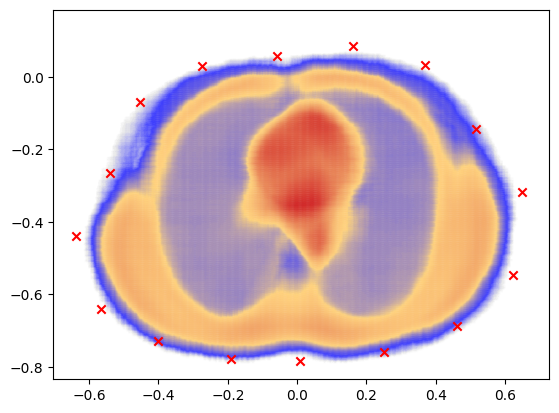

In [108]:
plt.scatter(points[0,:,0], -1*points[0,:,1], marker='x',s=0.01, c=pred.reshape(3,-1)[0],cmap=cmap)
plt.scatter(electrodes[0,:,0], -1*electrodes[0,:,1], marker='x', c='r')

## Show sagital/coronal

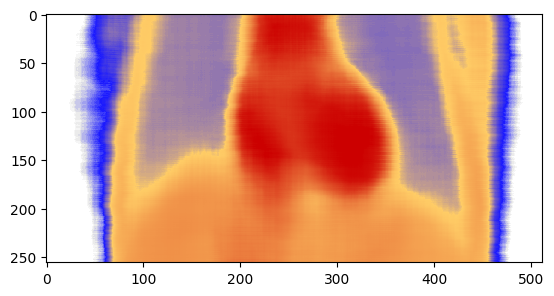

In [84]:
# for i in range(0,5):
protocol = '19'
n_zpos = 256
multiplier = 1000/4.5
test_signals_top = read_get('/home/nibdombe/deep_eit/data/raw/case_real/Tag1/Tag_01_Msg_'+protocol+'_SF_1_U_top_I_top_193-321_min_mean.get')[:208].reshape(-1,16,13)
test_signals_mid = read_get('/home/nibdombe/deep_eit/data/raw/case_real/Tag1/Tag_01_Msg_'+protocol+'_SF_2_U_mid_I_mid_193-321_min_mean.get')[:208].reshape(-1,16,13)
test_signals_bot = read_get('/home/nibdombe/deep_eit/data/raw/case_real/Tag1/Tag_01_Msg_'+protocol+'_SF_3_U_bot_I_bot_193-321_min_mean.get')[:208].reshape(-1,16,13)
test_signals = np.concatenate([test_signals_top, test_signals_mid, test_signals_bot], axis=0)*multiplier
test_electrodes = read_mat('data/raw/case_0/electrodes/electrodes.mat').reshape(-1, 16, 3)[[0,2,4]]
test_electrodes = test_electrodes - test_electrodes[0,0]
# test_electrodes_z = np.load('/home/nibdombe/deep_eit/data/processed/3d_15/case_TCIA_405_0/case_TCIA_405_0_20.npz')['electrodes']
# test_electrodes[:,:,2] = test_electrodes_z[:3,:,2]

pred = inference(model, test_signals, test_electrodes, n_zpos=n_zpos, z_padding=0.5, device=device)
plt.imshow(pred[:,220], cmap=cmap, vmin=0, vmax=0.7)
plt.show()

